In [95]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

#load the dataset
file_path = "/Users/ad0507/Downloads/Energy Consumption Time Series Forecasting/powerconsumption.csv"  # Path to the dataset
data = pd.read_csv(file_path)

In [96]:
#display the first few rows to understand the data structure
data.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [97]:
# Check for missing values and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [98]:
#convert 'Datetime' to datetime format and extract temporal features
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%m/%d/%Y %H:%M')

In [99]:
#extract features like hour, day, weekday, month, etc.
data['Hour'] = data['Datetime'].dt.hour
data['Day'] = data['Datetime'].dt.day
data['Weekday'] = data['Datetime'].dt.weekday
data['Month'] = data['Datetime'].dt.month

In [100]:
#create lag features for power consumption zones
lag_features = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']
for lag in range(1, 4):  # Lags of 1, 2, and 3 time steps
    for feature in lag_features:
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)

In [101]:
#create rolling statistics such as mean, std
for window in [3, 6]:  # windows of 3 and 6 time steps
    for feature in lag_features:
        data[f'{feature}_roll_mean{window}'] = data[feature].rolling(window=window).mean()
        data[f'{feature}_roll_std{window}'] = data[feature].rolling(window=window).std()

In [102]:
#drop rows with NaN values introduced by shifting and rolling operations
data.dropna(inplace=True)

#display the updated dataset structure
data.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Hour,...,PowerConsumption_Zone2_roll_mean3,PowerConsumption_Zone2_roll_std3,PowerConsumption_Zone3_roll_mean3,PowerConsumption_Zone3_roll_std3,PowerConsumption_Zone1_roll_mean6,PowerConsumption_Zone1_roll_std6,PowerConsumption_Zone2_roll_mean6,PowerConsumption_Zone2_roll_std6,PowerConsumption_Zone3_roll_mean6,PowerConsumption_Zone3_roll_std6
5,2017-01-01 00:50:00,5.853,76.9,0.081,0.059,0.108,26624.81013,17416.41337,18130.12048,0,...,17883.282673,472.435473,18490.602410,386.836384,29197.974683,2646.171166,18026.747720,1173.739887,19252.048193,890.249344
6,2017-01-01 01:00:00,5.641,77.7,0.080,0.048,0.096,25998.98734,16993.31307,17945.06024,1,...,17427.355623,439.615826,18172.530120,251.372313,27855.189873,1471.648370,18170.820668,919.766523,18869.397590,873.436189
7,2017-01-01 01:10:00,5.496,78.2,0.085,0.055,0.093,25446.07595,16661.39818,17459.27711,1,...,17023.708207,378.424210,17844.819277,346.473512,27127.088608,1386.518689,17718.541033,875.286975,18424.096385,777.339208
8,2017-01-01 01:20:00,5.678,78.1,0.081,0.066,0.141,24777.72152,16227.35562,17025.54217,1,...,16627.355623,384.111801,17476.626507,460.004480,26402.025317,1262.801944,17255.319148,788.353149,17983.614458,673.010210
9,2017-01-01 01:30:00,5.491,77.3,0.082,0.062,0.111,24279.49367,15939.20973,16794.21687,1,...,16275.987843,363.542101,17093.012050,337.624672,25743.797468,1143.815825,16851.671733,726.542706,17632.771085,648.443646


## Feature Engineering Process
To enhance the dataset and make it suitable for time-series modeling, the following feature engineering steps were implemented above:

### Temporal Feature Extraction:
From the Datetime column, key temporal features such as Hour, Day, Weekday, and Month were extracted to capture cyclical patterns and seasonal variations in power consumption.

### Lag Features:
Lagged features were created for the target variables (PowerConsumption_Zone1, PowerConsumption_Zone2, PowerConsumption_Zone3) to include power consumption values from previous time steps (e.g., lag1, lag2, lag3). These features help the model understand temporal dependencies and trends over time.

### Rolling Statistics:
Rolling mean and rolling standard deviation were calculated for a window of 3 and 6 time steps for each zone. These features provide insights into local trends and variability over short periods, enabling the model to account for recent fluctuations.

### Normalization:
All features were normalized using MinMaxScaler to ensure consistent scaling and improve the performance of the deep learning models.
These engineered features, combined with the original weather and environmental variables (Temperature, Humidity, etc.), formed a robust dataset for training advanced models like LSTM and GRU to capture temporal dependencies and seasonal trends effectively.


## EDA Analysis

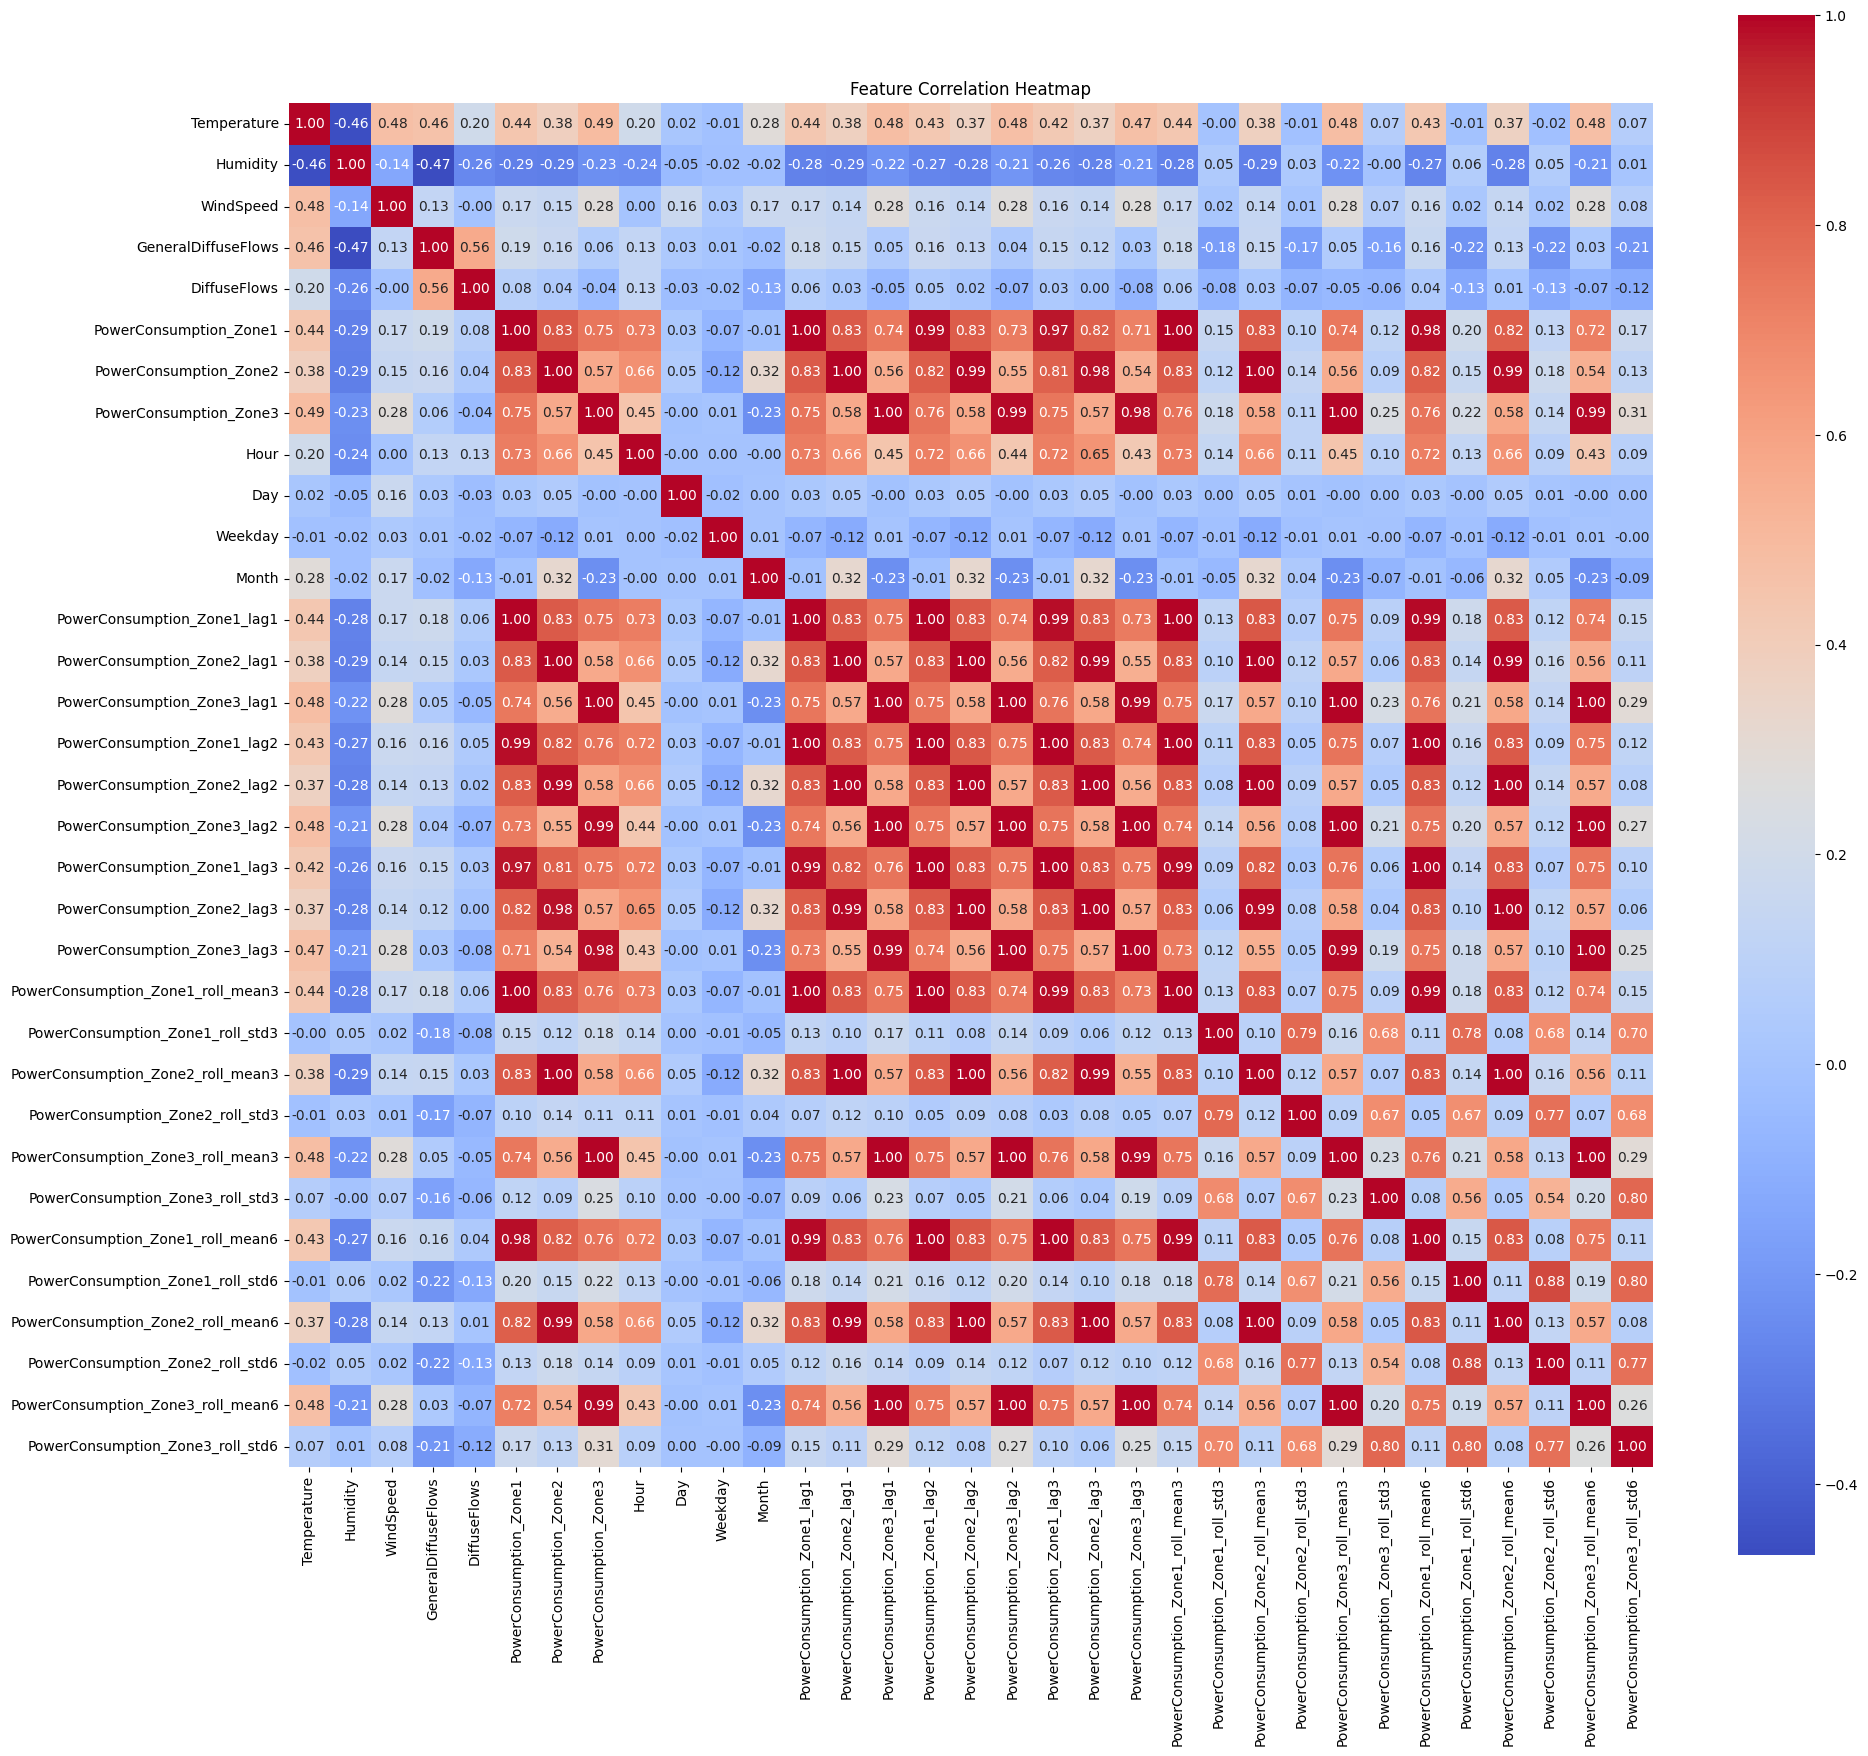

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap to understand feature relationships
def plot_correlation_heatmap(data, title="Feature Correlation Heatmap"):
    plt.figure(figsize=(22, 20))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
    plt.title(title)
    plt.show()

# Correlation heatmap for initial dataset (excluding datetime for correlation)
plot_correlation_heatmap(data.drop(columns=['Datetime']))


## Correlation Heatmap
- Observation: Strong correlations exist between the power consumption of different zones (PowerConsumption_Zone1, PowerConsumption_Zone2, PowerConsumption_Zone3). Temperature and Humidity show moderate correlation with power consumption, suggesting these environmental factors could be important predictors. Temporal features like Month and Hour may have weak correlations individually but could contribute valuable patterns over time.

- Use: These insights can guide feature engineering by focusing on lagged and rolling features for power consumption and incorporating environmental variables.

In [126]:
# Time-series plot of power consumption for Zone1
def plot_time_series(data, zone="PowerConsumption_Zone1"):
    plt.figure(figsize=(14, 6))
    plt.plot(data['Datetime'], data[zone], label=zone, alpha=0.7)
    plt.title(f"Time-Series Plot for {zone} (Before Feature Engineering)")
    plt.xlabel("Datetime")
    plt.ylabel("Power Consumption")
    plt.legend()
    plt.grid(True)
    plt.show()

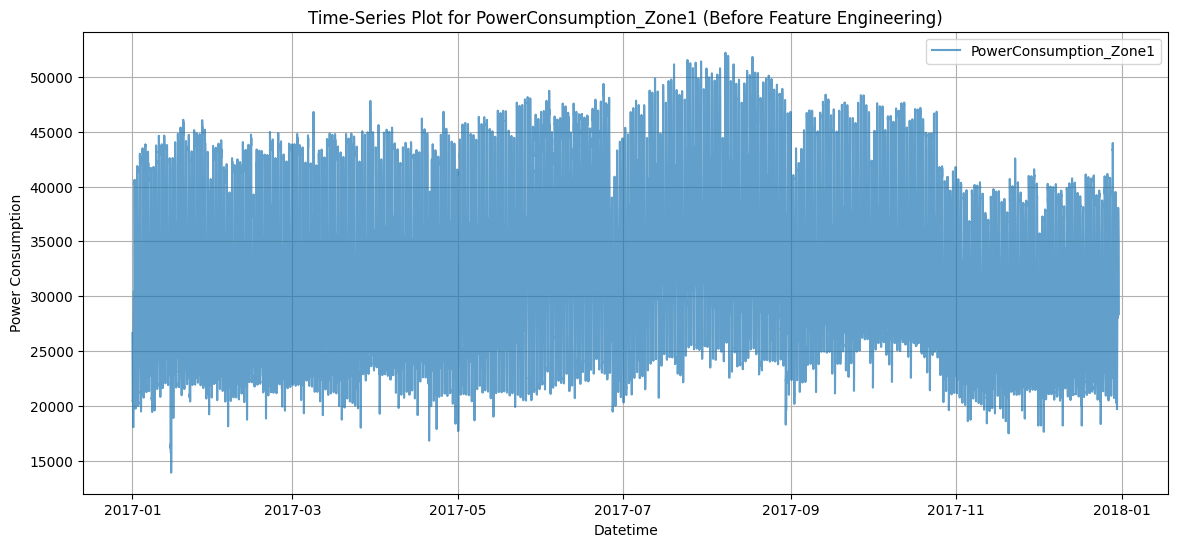

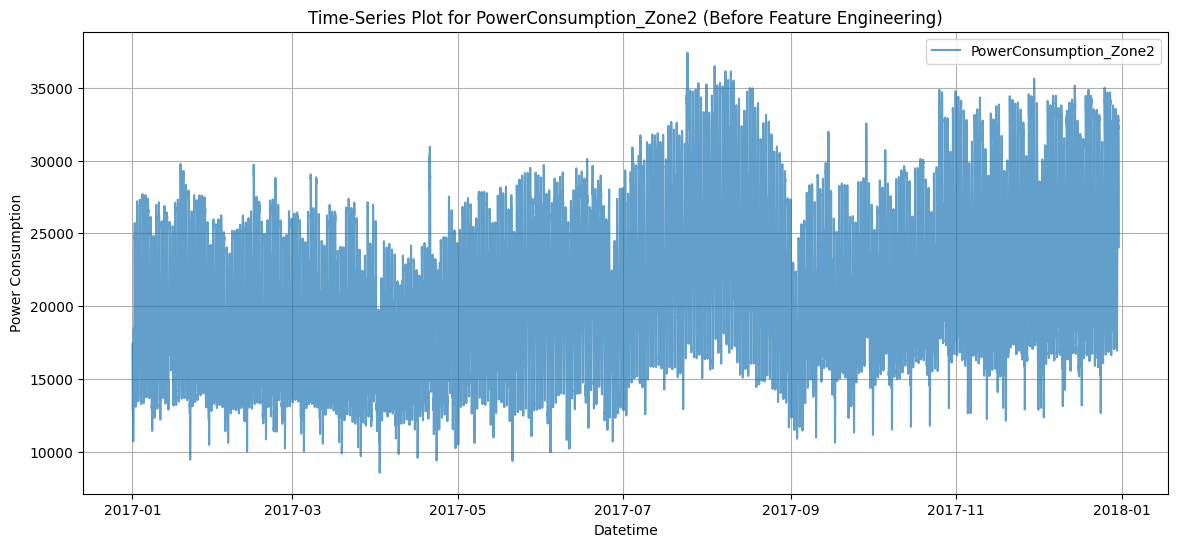

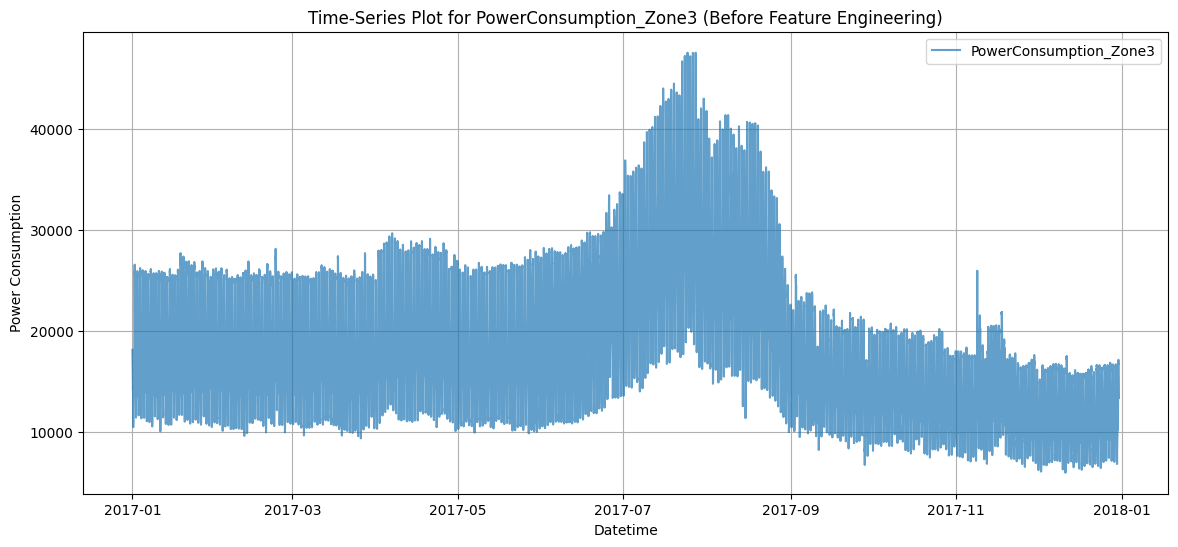

In [127]:
# Time-series plot for Zone1
plot_time_series(data, zone="PowerConsumption_Zone1")

# Time-series plot for Zone2
plot_time_series(data, zone="PowerConsumption_Zone2")

# Time-series plot for Zone3
plot_time_series(data, zone="PowerConsumption_Zone3")

## Time-Series Plot for Power Consumption
Based on the above plots, we have the following-
### Observation:
- Zone1: Relatively stable trends with noticeable peaks and troughs, potentially indicating daily or seasonal patterns.
- Zone2: More variation than Zone1, with pronounced peaks and dips, possibly influenced by external factors or operational cycles.
- Zone3: Displays significant seasonal variation, especially during mid-year, which could be linked to specific weather patterns or energy demand shifts.

### Use:
- These patterns emphasize the need for lagged features and rolling statistics to capture temporal dependencies effectively.
- Seasonal trends suggest that incorporating Month and Hour features might improve model performance.


# Feature Engineering

In [103]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#define the features and target variables
features = data.drop(columns=['Datetime', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'])
targets = data[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]

#initialize the scaler
scaler = MinMaxScaler()

#scale the features and targets
scaled_features = scaler.fit_transform(features)
scaled_targets = scaler.fit_transform(targets)

#prepare data for sequence models (e.g., LSTM, GRU, Transformers)
def create_sequences(features, targets, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(targets[i+sequence_length])
    return np.array(X), np.array(y)

#define sequence length (e.g., 24 for 24 time steps)
sequence_length = 24

#create sequences
X, y = create_sequences(scaled_features, scaled_targets, sequence_length)

#display the shapes of the resulting datasets
X.shape, y.shape

((52387, 24, 30), (52387, 3))

To prepare the data for time-series modeling with deep learning methods like LSTM, GRU, or Transformers, the following steps were performed:

### Feature and Target Separation:
The dataset was divided into features (environmental variables, temporal features, and lagged/rolling statistics) and target variables (PowerConsumption_Zone1, PowerConsumption_Zone2, PowerConsumption_Zone3).

### Normalization:
A MinMaxScaler was applied to scale both the features and target variables to a range of 0 to 1. This normalization ensures that all variables are on the same scale, improving model training stability and convergence.

### Sequence Creation:
A sliding window approach was used to generate sequences of length 24 (representing 24 time steps). For each sequence, the model input (X) comprises the scaled features for 24 consecutive time steps, and the output (y) corresponds to the scaled target values for the subsequent time step. This setup enables the model to learn temporal dependencies and predict future power consumption values.

### Output:
The resulting datasets (X and y) were reshaped into the appropriate format for time-series models. Each sequence (X) has a shape of (24, n_features), where n_features represents the number of input variables, while the target (y) has the corresponding values for the next time step.
This sequence preparation ensured the dataset was ready for training models that effectively capture temporal patterns and dependencies in power consumption data.








# Train-Test Split

In [105]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## LSTM Forecasting implementation

In [106]:
#define the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1])  # Output layer with 3 target variables
])

/Users/ad0507/Downloads/Energy Consumption Time Series Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [107]:
#compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [108]:
#define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [109]:
#train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0104 - mae: 0.0675 - val_loss: 0.0018 - val_mae: 0.0323
Epoch 2/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0015 - mae: 0.0290 - val_loss: 0.0015 - val_mae: 0.0288
Epoch 3/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 0.0020 - val_mae: 0.0346
Epoch 4/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 8.5730e-04 - mae: 0.0219 - val_loss: 0.0019 - val_mae: 0.0337
Epoch 5/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 7.1569e-04 - mae: 0.0199 - val_loss: 0.0023 - val_mae: 0.0381
Epoch 6/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 6.1838e-04 - mae: 0.0185 - val_loss: 0.0022 - val_mae: 0.0367
Epoch 7/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 5.6945e-04 - mae: 0.0177 - val_loss: 0.0020 - val_mae: 0.0332
Epoch 8/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 5.1842e-04 - mae: 0.0168 - val_loss: 0.0022 - val_mae: 0.0364
Epoch 9/50
1048/1048

In [110]:
#evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - mae: 0.0290
Test Loss: 0.0014591701328754425, Test MAE: 0.028975138440728188


### Understanding the Output above

**Test Loss (0.001459):**  This represents the mean squared error (MSE) on the test set. As the value is lower, this indicates better predictions relative to the actual values.

**Test MAE (0.028975):** The mean absolute error quantifies the average magnitude of errors in the model's predictions. As the value is smaller, this suggests that on average the model's predictions are very close to the actual values.

In summary, the evaluation metrics are good indicators of model performance, especially when compared to the scale of the target values. However, it's important to confirm this by visualizing and interpreting the results.



328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


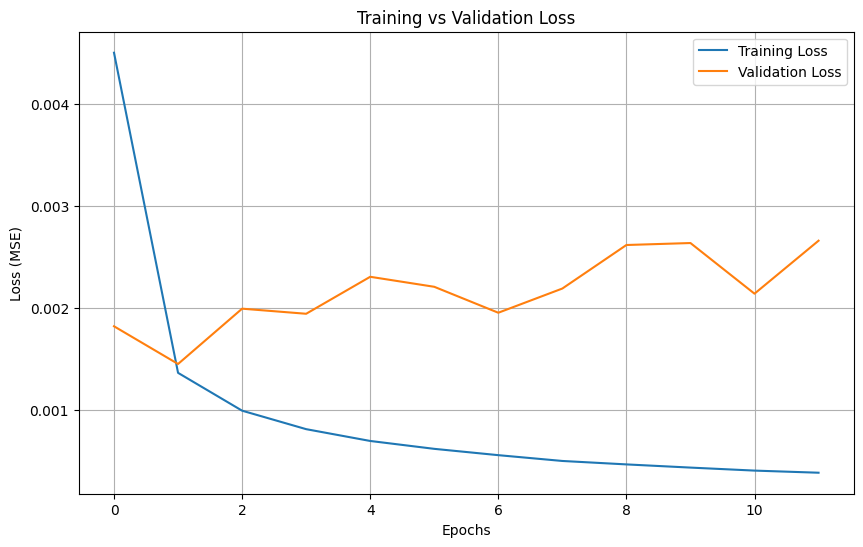

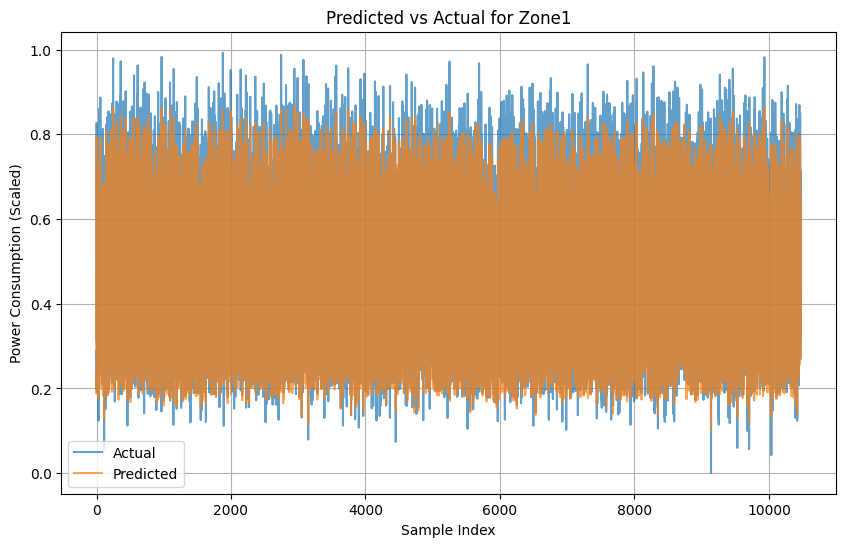

In [112]:
import matplotlib.pyplot as plt

#training vs validation loss plot
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

#predicted vs actual values plot
def plot_predictions(y_test, y_pred, zone_index=0, zone_name="Zone1"):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, zone_index], label='Actual', alpha=0.7)
    plt.plot(y_pred[:, zone_index], label='Predicted', alpha=0.7)
    plt.title(f'Predicted vs Actual for {zone_name}')
    plt.xlabel('Sample Index')
    plt.ylabel('Power Consumption (Scaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

#generate predictions on the test set
y_pred = model.predict(X_test)

#visualizations
plot_training_history(history)
plot_predictions(y_test, y_pred, zone_index=0, zone_name="Zone1")

### Training vs Validation Loss
**Observation:** 
- The training loss decreases steadily, indicating that the model is learning the patterns in the training data.
- The validation loss initially decreases but starts to oscillate and increase after a few epochs.
This behavior suggests that the model might be overfitting after a certain number of epochs.

### Predicted vs Actual for Zone1
**Observation:**
The predicted values align closely with the actual values, which indicates that the model captures the overall trend of the power consumption data.
However, there is some noise, which could result from high variability in the data or underfitting in certain scenarios.

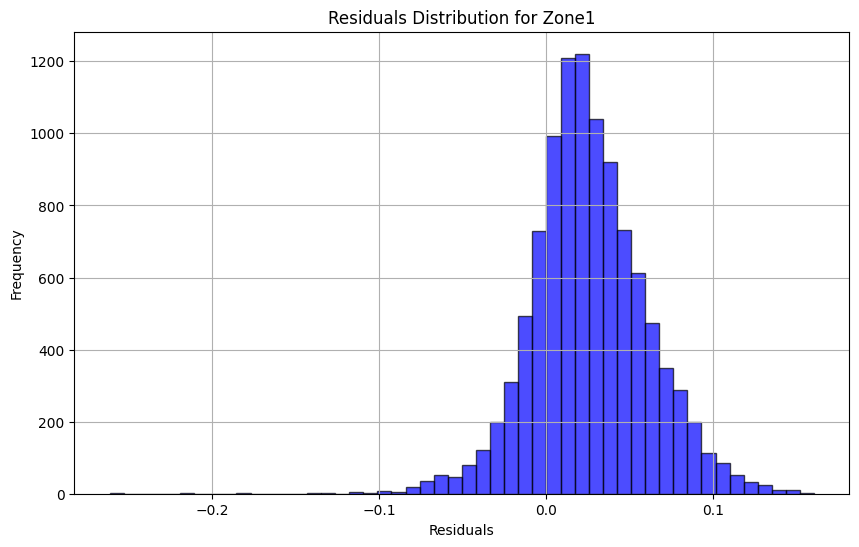

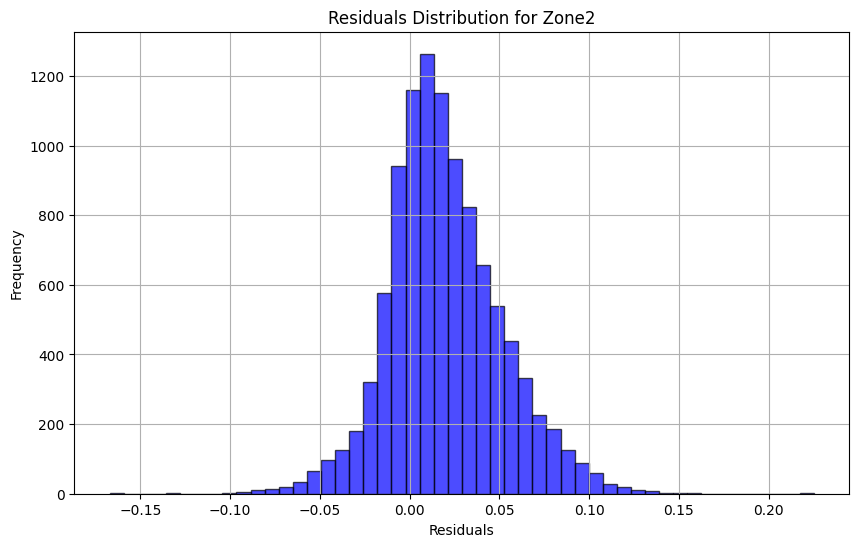

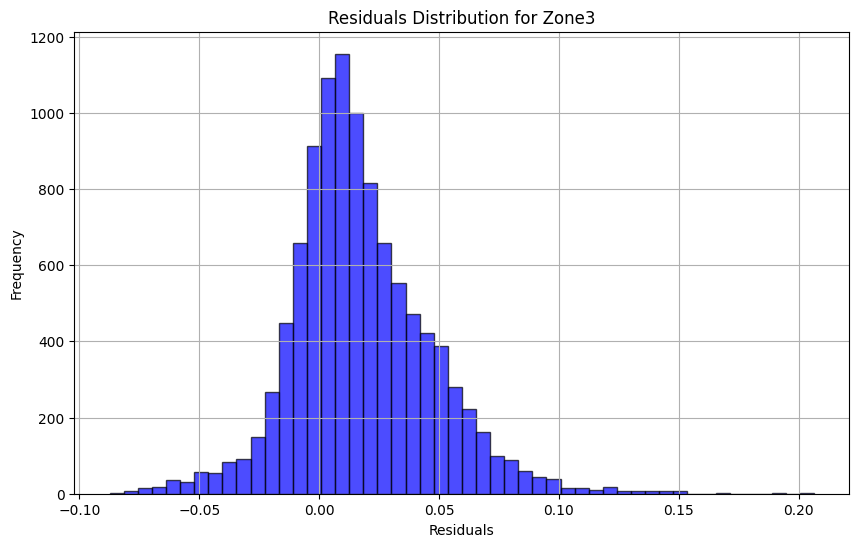

In [113]:
#residual Plot: Difference between Actual and Predicted values
def plot_residuals(y_test, y_pred, zone_index=0, zone_name="Zone1"):
    residuals = y_test[:, zone_index] - y_pred[:, zone_index]
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Residuals Distribution for {zone_name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#plot residuals 
plot_residuals(y_test, y_pred, zone_index=0, zone_name="Zone1")
plot_residuals(y_test, y_pred, zone_index=1, zone_name="Zone2")
plot_residuals(y_test, y_pred, zone_index=2, zone_name="Zone3")


## Analysis of Residual Plots

### Residual Distribution for Zone1, Zone2, and Zone3:
- The residuals (differences between actual and predicted values) are distributed around zero, which is a good sign that the model is unbiased in its predictions.
- The distributions are symmetric, showing that errors are evenly spread in both directions (overestimation and underestimation).
Key Observations:
- Most residuals are concentrated near zero, indicating the model predictions are generally close to the actual values.
- There are a few outliers (at the tails), which might represent occasional large errors. These could be due to sudden, unmodeled changes in the data or noise in the data.

# GRU Model Forecasting

In [114]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#define the GRU model
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(32, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1])  #output layer with 3 target variables
])

In [115]:
#compile the GRU model
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [116]:
#train the GRU model
gru_history = gru_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0088 - mae: 0.0638 - val_loss: 0.0011 - val_mae: 0.0246
Epoch 2/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0014 - mae: 0.0282 - val_loss: 7.8304e-04 - val_mae: 0.0207
Epoch 3/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0010 - mae: 0.0238 - val_loss: 0.0015 - val_mae: 0.0273
Epoch 4/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 8.2523e-04 - mae: 0.0216 - val_loss: 0.0019 - val_mae: 0.0341
Epoch 5/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 6.9180e-04 - mae: 0.0197 - val_loss: 0.0015 - val_mae: 0.0290
Epoch 6/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 6.2446e-04 - mae: 0.0185 - val_loss: 0.0035 - val_mae: 0.0468
Epoch 7/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 5.3347e-04 - mae: 0.0172 - val_loss: 0.0026 - val_mae: 0.0407
Epoch 8/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 4.9482e-04 - mae: 0.0164 - val_loss: 0.0030 - val_mae: 0.0452
Epoch 9/50
1048

In [117]:
#evaluate the GRU model
gru_test_loss, gru_test_mae = gru_model.evaluate(X_test, y_test, verbose=1)
print(f"GRU Test Loss: {gru_test_loss}, GRU Test MAE: {gru_test_mae}")

328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.9062e-04 - mae: 0.0209
GRU Test Loss: 0.0007836756412871182, GRU Test MAE: 0.020786168053746223


The GRU model's performance is better as compared to the LSTM forecasting, based on the metrics provided:

## Metrics Analysis:
**Test Loss (MSE):**
- GRU: 0.000783
- LSTM: 0.001459
The GRU model's test loss is significantly lower than the LSTM model's, meaning it has made smaller average squared errors on the test set.

**Test MAE:**
- GRU: 0.0209
- LSTM: 0.0290
The GRU model's MAE is also lower than the LSTM model's, indicating better performance in terms of absolute error.

### Key Observations:
- **GRU outperforms LSTM**: For this dataset and configuration, the GRU model has produced better results.

328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


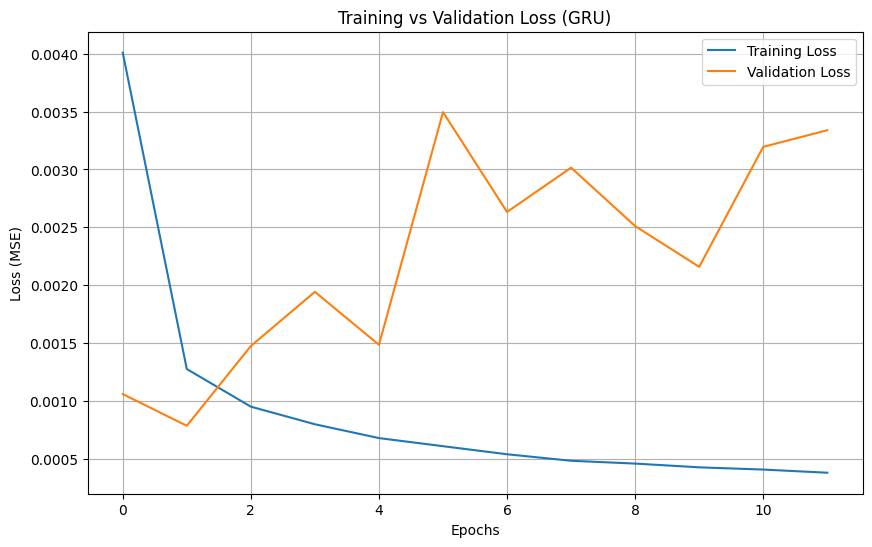

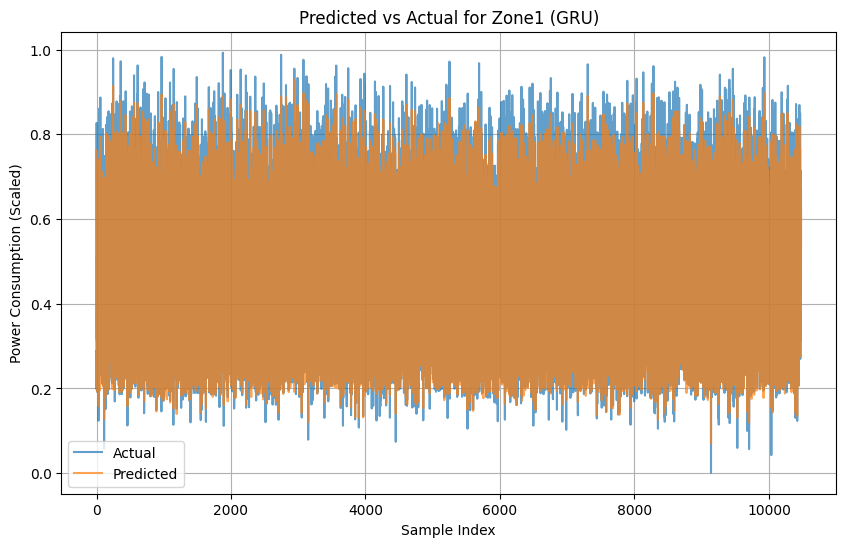

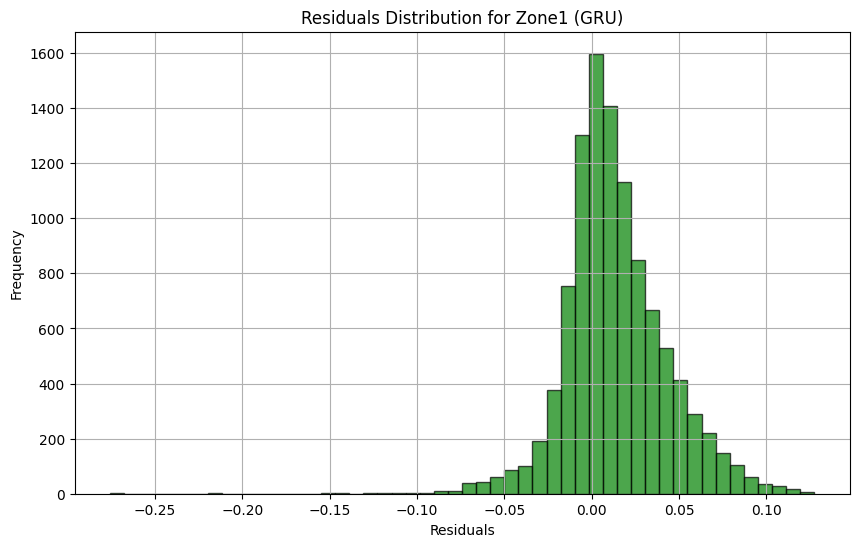

In [118]:
#training vs validation Loss plot for GRU
def plot_gru_training_history(gru_history):
    plt.figure(figsize=(10, 6))
    plt.plot(gru_history.history['loss'], label='Training Loss')
    plt.plot(gru_history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss (GRU)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

#predicted vs actual Values for GRU
def plot_gru_predictions(y_test, y_pred, zone_index=0, zone_name="Zone1"):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, zone_index], label='Actual', alpha=0.7)
    plt.plot(y_pred[:, zone_index], label='Predicted', alpha=0.7)
    plt.title(f'Predicted vs Actual for {zone_name} (GRU)')
    plt.xlabel('Sample Index')
    plt.ylabel('Power Consumption (Scaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

#residual plot for GRU
def plot_gru_residuals(y_test, y_pred, zone_index=0, zone_name="Zone1"):
    residuals = y_test[:, zone_index] - y_pred[:, zone_index]
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.title(f'Residuals Distribution for {zone_name} (GRU)')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#generate predictions for GRU
gru_y_pred = gru_model.predict(X_test)

#visualizations for GRU
plot_gru_training_history(gru_history)
plot_gru_predictions(y_test, gru_y_pred, zone_index=0, zone_name="Zone1")
plot_gru_residuals(y_test, gru_y_pred, zone_index=0, zone_name="Zone1")

## Analysis of GRU Model Visualizations

**Training vs Validation Loss**
- Observation:
    - The training loss decreases steadily, showing the model is learning effectively.
    - The validation loss fluctuates after the initial few epochs and does not decrease consistently.
    - Early stopping was triggered appropriately to prevent overfitting.

**Predicted vs Actual for Zone1**
- Observation:
    - The predicted values (orange) closely align with the actual values (blue), indicating the model is capturing the trends well.
    - Some noise is present, but overall alignment looks better than the LSTM model.

**Residuals Distribution for Zone1**
- Observation:
    - The residuals are centered around 0 and exhibit a normal distribution, which is a positive sign.
    - Most errors are small, indicating accurate predictions, but there are some minor outliers in the tails.

# Compare LSTM and GRU models

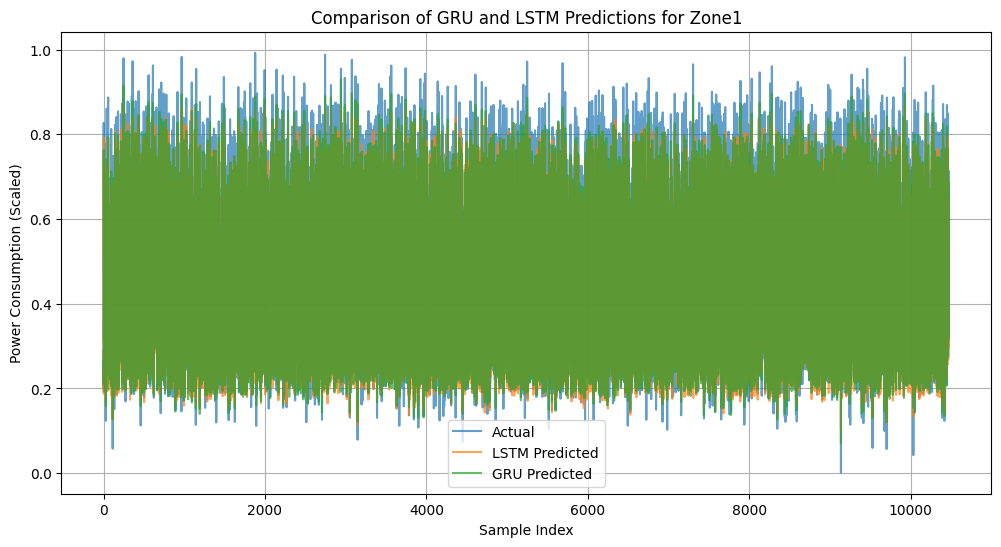

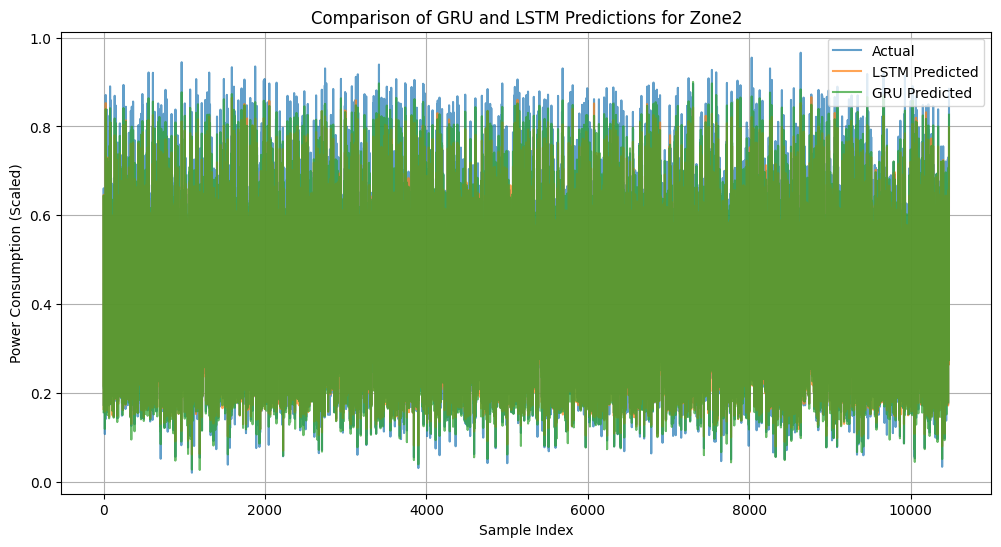

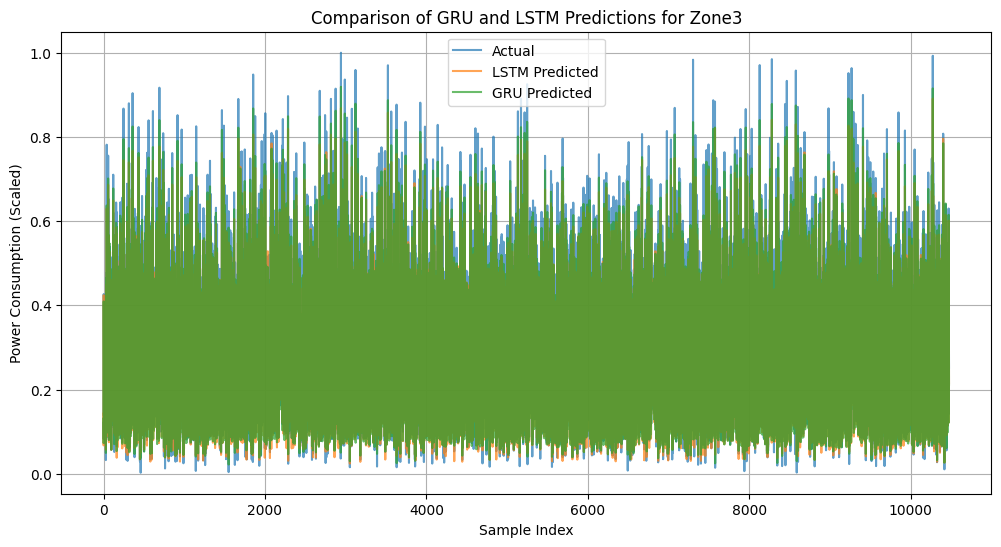

In [119]:
# Plot comparison of GRU and LSTM predictions for Zone1
def compare_predictions(y_test, lstm_y_pred, gru_y_pred, zone_index=0, zone_name="Zone1"):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, zone_index], label='Actual', alpha=0.7)
    plt.plot(lstm_y_pred[:, zone_index], label='LSTM Predicted', alpha=0.7)
    plt.plot(gru_y_pred[:, zone_index], label='GRU Predicted', alpha=0.7)
    plt.title(f'Comparison of GRU and LSTM Predictions for {zone_name}')
    plt.xlabel('Sample Index')
    plt.ylabel('Power Consumption (Scaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming lstm_y_pred and gru_y_pred are available (predictions for LSTM and GRU models)
# Compare predictions for Zone1
compare_predictions(y_test, y_pred, gru_y_pred, zone_index=0, zone_name="Zone1")

# Compare predictions for Zone2
compare_predictions(y_test, y_pred, gru_y_pred, zone_index=1, zone_name="Zone2")

# Compare predictions for Zone3
compare_predictions(y_test, y_pred, gru_y_pred, zone_index=2, zone_name="Zone3")

## Analysis of GRU vs LSTM Predictions

### Zone1 Comparison
- Observations:
    - Both GRU and LSTM predictions closely follow the actual data.
    - GRU appears slightly smoother and more aligned with the actual values in areas of variability.
    - LSTM predictions exhibit minor deviations in regions with sudden changes.

- Inference:
    - GRU likely handles the patterns and fluctuations in the data more effectively than LSTM for Zone1.

### Zone2 Comparison
- Observations:
    - GRU predictions align better with actual values compared to LSTM.
    - LSTM shows slightly more noise and less adaptability to sharp variations in the data.

- Inference:
    - GRU again demonstrates better generalization and smoother predictions for Zone2.

### Zone3 Comparison
- Observations:
    - Both GRU and LSTM capture the general trend, but GRU predictions are more consistent and closer to the actual values.
    - LSTM exhibits minor lag or overfitting in specific regions.
- Inference:
    - GRU outperforms LSTM in Zone3 as well, maintaining accuracy with lower variability.

In [ ]:
# Initialize the Prophet model
model = Prophet()

# Fit the model to the data
print("Training Prophet model...")
model.fit(prophet_data)